In [2]:
!pip install pyvis
!pip install obonet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.8 MB/s eta 0:00:00a 0:00:01


In [3]:
!pip install biopython
!pip install progressbar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 36.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12066 sha256=48880542d563466a3d52eff25057da76398e13a05e589f4eec209f81b60aa86c
  Stored in directory: /root/.cache/pip/wheels/cd/17/e5/765d1a3112ff3978f70223502f6047e06c43a24d7c5f8ff95b
Successfully built progressbar


In [4]:
!pip install tensorflow

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import progressbar

In [6]:
train_terms=pd.read_csv('/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv', sep="\t")
train_terms.head()
train_terms

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO
...,...,...,...
5363858,X5L565,GO:0050649,MFO
5363859,X5L565,GO:0016491,MFO
5363860,X5M5N0,GO:0005515,MFO
5363861,X5M5N0,GO:0005488,MFO


In [7]:
train_terms.shape

(5363863, 3)

In [8]:
import os
import json
from typing import Dict
from collections import Counter

import random
import obonet
import pandas as pd
import numpy as np
from Bio import SeqIO
import re
from transformers import T5Tokenizer, T5EncoderModel
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False) #.to(device)

# Load the model
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc").to(device)

def get_embeddings(seq):
    sequence_examples = [" ".join(list(re.sub(r"[UZOB]", "X", seq)))]

    ids = tokenizer.batch_encode_plus(sequence_examples, add_special_tokens=True, padding="longest")

    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    # generate embeddings
    with torch.no_grad():
        embedding_repr = model(input_ids=input_ids,
                               attention_mask=attention_mask)

    # extract residue embeddings for the first ([0,:]) sequence in the batch and remove padded & special tokens ([0,:7]) 
    emb_0 = embedding_repr.last_hidden_state[0]
    emb_0_per_protein = emb_0.mean(dim=0)
    
    return emb_0_per_protein

file = '/kaggle/input/cafa-5-protein-function-prediction/Train/train_sequences.fasta'
sequences = SeqIO.parse(file, "fasta")
print(sequences)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/2.42G [00:00<?, ?B/s]

In [9]:
print(next(iter(sequences)).seq)

MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIPDKFFIQLKQPLRNKRVCVCGIDPYPKDGTGVPFESPNFTKKSIKEIASSISRLTGVIDYKGYNLNIIDGVIPWNYYLSCKLGETKSHAIYWDKISKLLLQHITKHVSVLYCLGKTDFSNIRAKLESPVTTIVGYHPAARDRQFEKDRSFEIINVLLELDNKVPINWAQGFIY


In [10]:
sequences = SeqIO.parse(file, "fasta")
sequences


In [11]:
get_embeddings(str(next(iter(sequences)).seq))

tensor([ 0.0495, -0.0329,  0.0325,  ..., -0.0435,  0.0965,  0.0731],
       device='cuda:0')

In [12]:
train_protein_ids = np.load('/kaggle/input/t5embeds/train_ids.npy')
train_protein_ids_pd=pd.DataFrame(train_protein_ids)
train_protein_ids_pd

,0
0,P20536
1,O73864
2,O95231
3,A0A0B4J1F4
4,P54366
...,...
142241,A0A286YAI0
142242,A0A1D5NUC4
142243,Q5RGB0
142244,A0A2R8QMZ5


In [13]:
train_protein_ids_pd.size

142246

In [14]:
train_embeddings = np.load('/kaggle/input/t5embeds/train_embeds.npy')
column_num = train_embeddings.shape[1]
train_df  = pd.DataFrame(train_embeddings, columns = ["Colomn " + str(i) for i in range(1, column_num+1)])
train_df

,Colomn 1,Colomn 2,Colomn 3,Colomn 4,Colomn 5,Colomn 6,Colomn 7,Colomn 8,Colomn 9,Colomn 10,...,Colomn 1015,Colomn 1016,Colomn 1017,Colomn 1018,Colomn 1019,Colomn 1020,Colomn 1021,Colomn 1022,Colomn 1023,Colomn 1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142241,0.032529,0.032490,0.026844,0.007486,-0.019346,0.033527,0.048294,-0.091146,0.007092,0.008843,...,-0.038719,-0.037237,-0.022644,-0.055443,0.002142,0.006521,-0.026665,-0.002415,0.016886,0.004104
142242,0.056026,0.035470,0.021987,0.028443,-0.001087,0.020100,-0.010549,-0.049460,0.027347,-0.028113,...,-0.020552,-0.030632,-0.038549,-0.011747,0.060145,0.003906,-0.031132,0.003377,-0.027095,-0.015910
142243,0.016918,0.041331,0.000793,-0.005990,-0.039993,0.056007,-0.013786,-0.076081,0.006320,-0.002054,...,-0.029348,-0.037351,0.008763,-0.051209,0.028266,0.009462,0.019854,0.008808,0.006481,-0.013350
142244,0.061252,0.083402,0.044025,0.047916,0.024477,0.035183,-0.016680,-0.043163,-0.045596,-0.029994,...,-0.014085,0.020183,-0.066376,0.058274,0.056035,-0.002282,-0.013941,0.001384,-0.047546,0.010124


In [15]:
#There are more than 50,000 labels in the train_terms.tsv file, so we will choose the most frequent 1500 GO term IDs as labels of the dataset.
#Extracting Go IDs
num_of_labels = 1500
labels = train_terms['term'].value_counts().index
labels=labels[:num_of_labels]
labels

Index(['GO:0005575', 'GO:0008150', 'GO:0110165', 'GO:0003674', 'GO:0005622',
       'GO:0009987', 'GO:0043226', 'GO:0043229', 'GO:0005488', 'GO:0043227',
       ...
       'GO:0031345', 'GO:0140053', 'GO:0034250', 'GO:0098802', 'GO:0045861',
       'GO:0001818', 'GO:0031674', 'GO:0051783', 'GO:0070828', 'GO:0016887'],
      dtype='object', name='term', length=1500)

In [16]:
# Extracting the dataset which contains the top 1500(labels) GO terms
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]
train_terms_updated=train_terms_updated.reset_index(drop=True)
train_terms_updated

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0044270,BPO
3,A0A009IHW8,GO:0006753,BPO
4,A0A009IHW8,GO:0044237,BPO
...,...,...,...
4420732,X5L565,GO:0003674,MFO
4420733,X5L565,GO:0016491,MFO
4420734,X5M5N0,GO:0005515,MFO
4420735,X5M5N0,GO:0005488,MFO


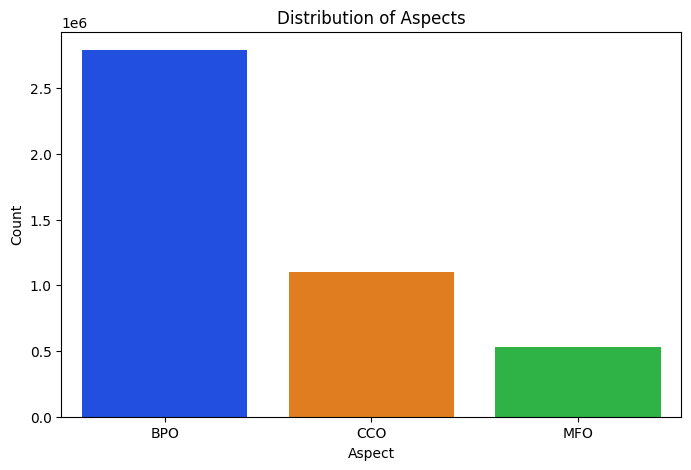

In [17]:
bar_df = train_terms_updated['aspect'].value_counts()

plt.figure(figsize=(8, 5))

sns.barplot(x=bar_df.index, y=bar_df.values, palette="bright")

plt.xlabel("Aspect")
plt.ylabel("Count")
plt.title("Distribution of Aspects")

plt.show()


In [18]:
train_size = train_protein_ids.shape[0]
train_labels = np.zeros((train_size ,num_of_labels))
series_train_protein_ids = pd.Series(train_protein_ids)

bar = progressbar.ProgressBar(maxval=num_of_labels, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for i in range(num_of_labels):
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]
    label_related_proteins = n_train_terms['EntryID'].unique()
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)
    bar.update(i+1)
bar.finish()

[============================================================================================] 100%


In [19]:
!mkdir /kaggle/working/labels
labels_df = pd.DataFrame(data = train_labels, columns = labels)
labels_df.to_csv('/kaggle/working/labels/kaggledata.csv')

In [20]:
labels_df.shape

(142246, 1500)

**Training**

In [21]:
train_df.shape

(142246, 1024)

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split the data into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_df, labels_df, test_size=0.2, random_state=42)

# Define model architecture
INPUT_SHAPE = [train_df.shape[1]]
num_of_labels = labels_df.shape[1]

BATCH_SIZE = 512

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=num_of_labels, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()]
)

# Train the model with validation split
history = model.fit(
    train_data,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_data, val_labels)
)




/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - auc: 0.7296 - binary_accuracy: 0.9428 - loss: 0.1643 - val_auc: 0.8762 - val_binary_accuracy: 0.9802 - val_loss: 0.3243
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - auc: 0.8622 - binary_accuracy: 0.9802 - loss: 0.0737 - val_auc: 0.9038 - val_binary_accuracy: 0.9805 - val_loss: 0.1318
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8864 - binary_accuracy: 0.9804 - loss: 0.0700 - val_auc: 0.9143 - val_binary_accuracy: 0.9806 - val_loss: 0.0757
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - auc: 0.8979 - binary_accuracy: 0.9804 - loss: 0.0682 - val_auc: 0.9186 - val_binary_accuracy: 0.9808 - val_loss: 0.0674
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - auc: 0.9039 - binary_accuracy: 0.9805 - loss: 0.0669 - val_auc: 0.9216 - val_binary_accuracy: 0.9809 - val_loss: 0.0652
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - auc: 0.9086 - binary_accuracy: 0.9807 - loss: 0.0656 - val_auc: 0.9234 - v

In [23]:
# Get the final training and validation metrics
final_train_metrics = model.evaluate(train_data, train_labels, verbose=0)
final_val_metrics = model.evaluate(val_data, val_labels, verbose=0)

# Display in the desired format
print("\nFinal Training Metrics:")
print("Loss:", final_train_metrics[0])
print("Binary Accuracy:", final_train_metrics[2])
print("AUC:", final_train_metrics[1])

print("\nFinal Validation Metrics:")
print("Loss:", final_val_metrics[0])
print("Binary Accuracy:", final_val_metrics[2])
print("AUC:", final_val_metrics[1])



Final Training Metrics:
Loss: 0.05626029893755913
Binary Accuracy: 0.9447396993637085
AUC: 0.9818550944328308

Final Validation Metrics:
Loss: 0.05915827676653862
Binary Accuracy: 0.9331939816474915
AUC: 0.9814189672470093


In [24]:
model.save("/kaggle/working/model1.h5")

In [25]:
model.save_weights("/kaggle/working/model.weights.h5")

In [26]:
model.load_weights("/kaggle/working/model.weights.h5")

In [27]:
custom_input_tensor = np.array([[1 for i in range(1024)]])
print(custom_input_tensor)
print(len(custom_input_tensor[0]))
# Get predictions for custom input tensor
predictions = model.predict(custom_input_tensor)

# 'predictions' will contain the model's output for the custom input tensor
print(predictions)
for i in predictions[0]:
    x=0 if i<0.5 else 1
    #print(x)
# print(len(predictions))


[[1 1 1 ... 1 1 1]]
1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
[[2.1070905e-01 2.1817710e-01 1.9502871e-01 ... 4.5250476e-07
  7.1514759e-09 2.0716642e-10]]


<Axes: title={'center': 'Accuracy'}>

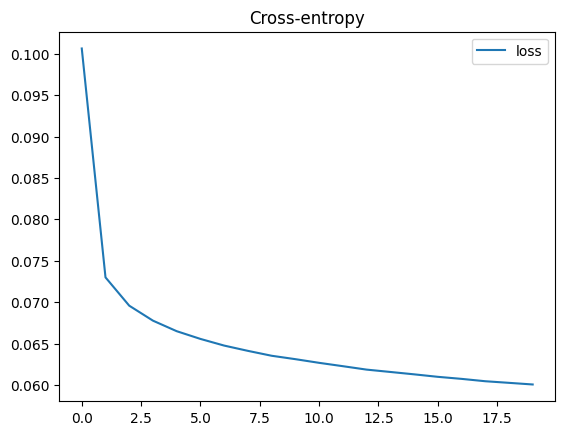

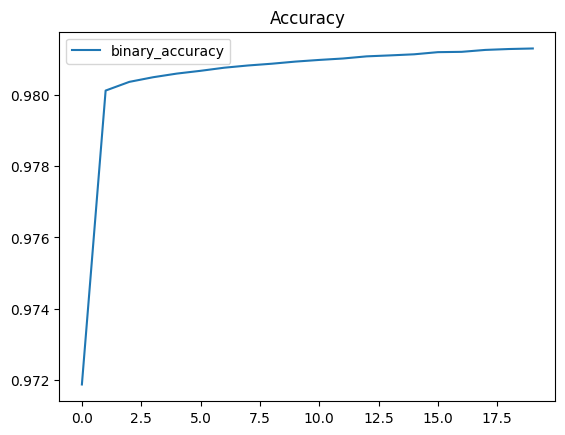

In [28]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy']].plot(title="Accuracy")

In [29]:
import tqdm
from Bio import SeqIO
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import json
from typing import Dict
from collections import Counter
import random
import obonet
from transformers import T5Tokenizer, T5EncoderModel
import torch
import re

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False) #.to(device)

# Load the model
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc").to(device)

def get_embeddings(seq):
    sequence_examples = [" ".join(list(re.sub(r"[UZOB]", "X", seq)))]

    ids = tokenizer.batch_encode_plus(sequence_examples, add_special_tokens=True, padding="longest")

    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    # generate embeddings
    with torch.no_grad():
        embedding_repr = model(input_ids=input_ids,
                               attention_mask=attention_mask)

    # extract residue embeddings for the first ([0,:]) sequence in the batch and remove padded & special tokens ([0,:7])
    emb_0 = embedding_repr.last_hidden_state[0]
    emb_0_per_protein = emb_0.mean(dim=0)

    return emb_0_per_protein

def predict(fasta_file):
    sequences = SeqIO.parse(fasta_file, "fasta")

    ids = []
    num_sequences=sum(1 for seq in sequences)
    embeds = np.zeros((num_sequences, 1024))
    i = 0
    with open(fasta_file, "r") as fastafile:
      # Iterate over each sequence in the file
      for sequence in SeqIO.parse(fastafile, "fasta"):
        seq_id = sequence.id
        seq_data = str(sequence.seq)
        embeds[i] = get_embeddings(seq_data).detach().cpu().numpy()
        ids.append(seq_id)
        i += 1
        
    INPUT_SHAPE=[1024]
    num_of_labels=1500

    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),
        tf.keras.layers.Dense(units=256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=num_of_labels, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['binary_accuracy', tf.keras.metrics.AUC()]
    )
    
    model.load_weights('/kaggle/working/model.weights.h5') #load model here
    labels_df=pd.read_csv('/kaggle/input/labels/kaggledata.csv')
    labels_df=labels_df.drop(columns='Unnamed: 0')

    predictions = model.predict(embeds)
    predictions_list1=[]
    predictions_list2=[]

    # 'predictions' will contain the model's output for the custom input tensor
    for prediction in predictions:
        tmp=[]
        t2=[]
        for i in prediction:
            x=0 if i<0.4 else 1
            tmp.append(x)
            t2.append(i)
        predictions_list1.append(tmp.copy())
        predictions_list2.append(t2.copy())

    label_columns = labels_df.columns

    # Convert the predictions into a DataFrame
    predictions_df = pd.DataFrame(predictions_list1, columns=label_columns)
    p21=pd.DataFrame(predictions_list2, columns=label_columns)

    # Save the DataFrame to a CSV file
    predictions_df.to_csv("predictions.csv", index=False)
    p21.to_csv("decimal.csv",index=False)
    print(predictions_df.shape)
    
    


In [30]:
predict('/kaggle/input/fastaexample/example.fasta') 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
(1, 1500)
